<a href="https://colab.research.google.com/github/Nishashams/Benchmarking-SR-RACD/blob/main/Eduxlab_CNN_Segmentation_Roads_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!unzip "/content/drive/MyDrive/DL Satellite/Roads _Extraction.zip" -d "/content/drive/MyDrive/DL Satellite/"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display the Image data
from PIL import Image
import cv2
import os
from glob import glob
from sklearn.utils import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.listdir("/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction")

['Train', 'Valid', 'Test']

In [ ]:
data_path = "/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Train"
mask_files = sorted(glob(data_path + "/*mask.png"))
sat_files = sorted(glob(data_path + "/*sat.jpg"))
print(len(mask_files), len(sat_files))

250 250


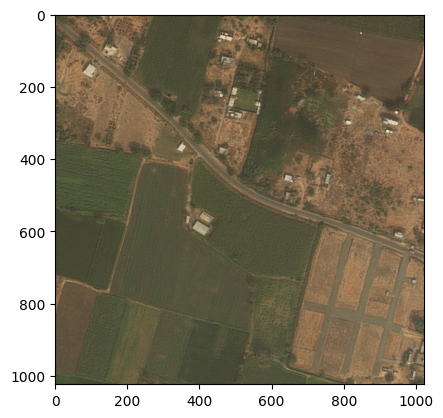

In [ ]:
img = plt.imread(sat_files[129])
plt.imshow(img)

For masking we can use Image Masking , mask a color image using OpenCV,
Binary Mask,
Contours

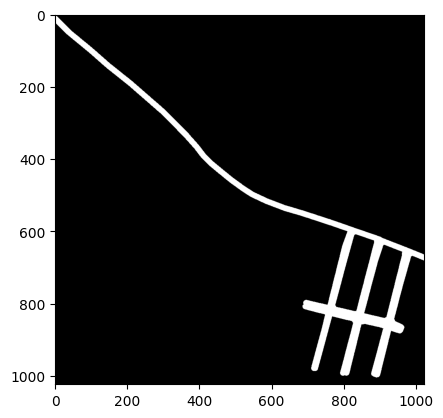

In [ ]:
img = plt.imread(mask_files[129])
plt.imshow(img)

In [ ]:
sat_files[0]

'/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Train/15347_sat.jpg'

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def load_data(data_path, split=0.2):
    masks = sorted(glob(data_path + '/*mask.png'))
    images = sorted(glob(data_path + '/*sat.jpg'))
    size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.2, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=0.2, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(data_path)

In [ ]:
len(train_x), len(train_y), len(valid_x), len(valid_y), len(test_x), len(test_y)

(160, 160, 50, 50, 40, 40)

In [ ]:
def read_image(path):
    img = Image.open(path)
    img = img.resize((W, H))
    x = np.array(img, dtype=np.float32)
    x = x / 255.0
    return x

In [ ]:
def read_mask(path):
    img = Image.open(path).convert('L')
    img = img.resize((W, H))
    x = np.array(img, dtype=np.float32)
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [ ]:
def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)

    return dataset

In [ ]:
H = 256
W = 256
batch_size = 8
learning_rate = 0.0001

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = (len(train_x) // batch_size)
valid_steps = (len(valid_x) // batch_size)

#### Build Segmentation Model

In [ ]:
def unet(input_shape):
    inputs = Input(shape = input_shape)
    # Encoder Part
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2,2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2,2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2,2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides = (2,2), padding = 'same')(conv5)
    concat6 = concatenate([up6, conv4], axis = -1)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(concat6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides = (2,2), padding = 'same')(conv6)
    concat7 = concatenate([up7, conv3], axis = -1)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(concat7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides = (2,2), padding = 'same')(conv7)
    concat8 = concatenate([up8, conv2], axis = -1)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(concat8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2DTranspose(128, 2, strides = (2,2), padding = 'same')(conv8)
    concat9 = concatenate([up9, conv1], axis = -1)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(concat9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)

    #Output layer
    outputs = Conv2D(1,1,padding="same", activation="sigmoid")(conv9)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
input_shape = (256, 256, 3)  # Adjust input shape according to your images
model = unet(input_shape)

In [ ]:
model = unet((H,W,3))
metrics = ['accuracy',Recall(), Precision()]
model.compile(loss="binary_crossentropy",
             optimizer=Adam(learning_rate),
             metrics=metrics)

In [ ]:
from tensorflow.keras import callbacks
filepath = "/content/drive/MyDrive/EDUXLAB/Roads_Segmentation.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor = 'val_loss', save_best_only = True,
                                       mode = 'min', verbose = 1)
callbacks_list = [checkpoint]

In [ ]:
'''history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=valid_dataset,
                    steps_per_epoch=train_steps,
                    validation_steps=valid_steps,
                    callbacks= checkpoint)'''

'history = model.fit(train_dataset,\n                    epochs=10,\n                    validation_data=valid_dataset,\n                    steps_per_epoch=train_steps,\n                    validation_steps=valid_steps,\n                    callbacks= checkpoint)'

In [ ]:
#### Performance Metrics

In [ ]:
'''
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)
# Plot the loss curves
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
'''

"\ntraining_loss = history.history['loss']\nvalidation_loss = history.history['val_loss']\n\nepochs = range(1, len(training_loss) + 1)\n# Plot the loss curves\nplt.plot(epochs, training_loss, label='Training Loss')\nplt.plot(epochs, validation_loss, label='Validation Loss')\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()\n"

In [ ]:
model.load_weights("/content/drive/MyDrive/EDUXLAB/Roads_Segmentation.hdf5")

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)
model.evaluate(test_dataset)

5/5 [==============================] - 8s 574ms/step - loss: 0.1545 - accuracy: 0.9517 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00


[0.15447081625461578, 0.9517181515693665, 0.0, 0.0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage import io
from skimage.transform import resize

In [ ]:
# Load pre-trained U-Net model
model = load_model('/content/drive/MyDrive/EDUXLAB/Roads_Segmentation.hdf5')

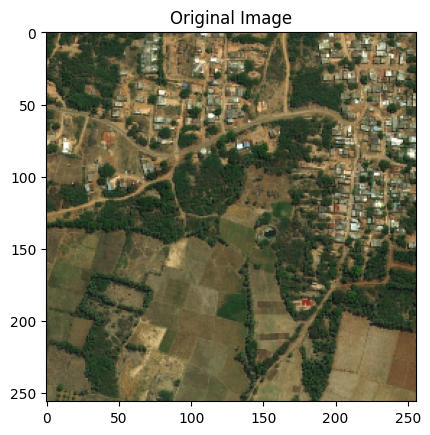

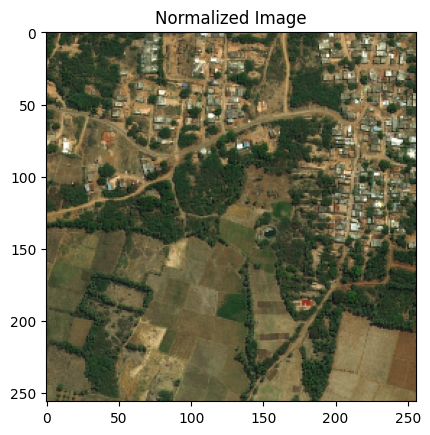

In [ ]:
import cv2

# Load and preprocess the satellite image
image_path = '/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Test/10206_sat.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
image = cv2.resize(image, (256, 256))  # Resize to match input size of the model

# Display the image before normalization
plt.imshow(image)
plt.title('Original Image')
plt.show()

# Normalize and prepare the image for segmentation
image = np.expand_dims(image, axis=0)  # Add batch dimension
image = image.astype(np.float32)  # Convert to float32
image /= 255.0  # Normalize pixel values

# Display the normalized image
plt.imshow(image[0])
plt.title('Normalized Image')
plt.show()


In [ ]:
# Perform road segmentation
segmentation_map = model.predict(image)


1/1 [==============================] - 0s 252ms/step


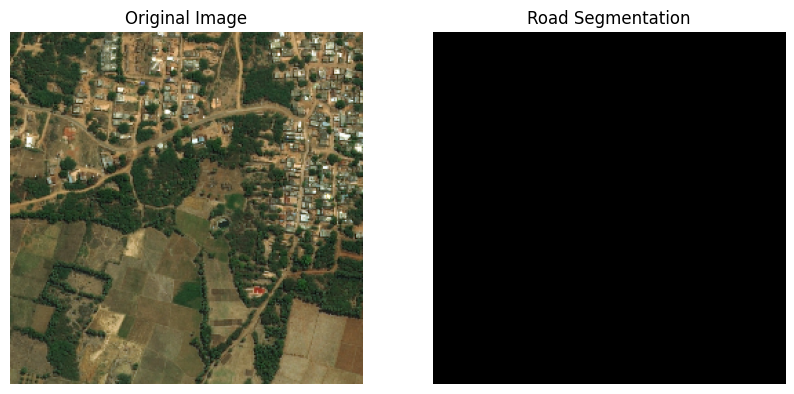

In [ ]:

# Threshold segmentation map to obtain binary mask
threshold = 0.5
road_mask = (segmentation_map > threshold).astype(np.uint8)

# Visualize the original image and segmented road
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(road_mask[0].squeeze(), cmap='gray')
plt.title('Road Segmentation')
plt.axis('off')
plt.show()


17/04/2024

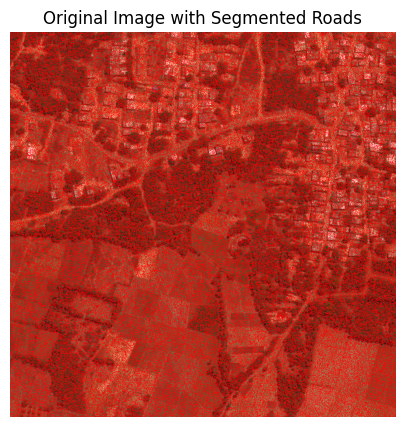

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the satellite image
image_path = '/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Test/10206_sat.jpg'
image = Image.open(image_path)

# Assuming you have already obtained the road mask
# Perform segmentation on the image to obtain the road mask
# For demonstration purposes, let's create a sample road mask
segmentation_map = np.random.rand(image.size[1], image.size[0])  # Assuming the same size as the image
threshold = 0.5
road_mask = (segmentation_map > threshold).astype(np.uint8)

# Overlay the road mask on the original image
overlayed_image = np.array(image)
overlayed_image[:, :, 0][road_mask == 1] = 255  # Set red channel to max where road is detected
overlayed_image[:, :, 1][road_mask == 1] = 0    # Set green channel to 0 where road is detected
overlayed_image[:, :, 2][road_mask == 1] = 0    # Set blue channel to 0 where road is detected

# Display the original image with the segmented roads overlaid
plt.figure(figsize=(10, 5))
plt.imshow(overlayed_image)
plt.title('Original Image with Segmented Roads')
plt.axis('off')
plt.show()


In [ ]:
pip install opencv-python


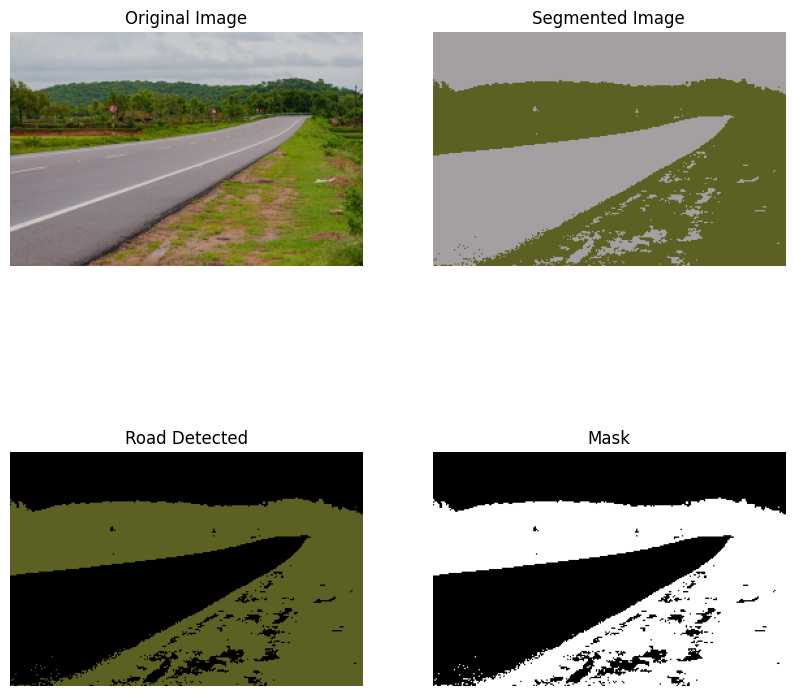

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def segment_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply K-means clustering
    Z = image.reshape((-1,3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2 # Number of clusters
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Reshape label to the size of original image
    label = label.reshape(image.shape[:2])

    # Assign a color to each cluster
    segmented_image = np.zeros_like(image)
    for i in range(K):
        segmented_image[label == i] = np.mean(image[label == i], axis=0)

    return segmented_image

def detect_road(image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define range of yellow color in HSV
    lower_yellow = np.array([18, 80, 80])
    upper_yellow = np.array([35, 255, 255])

    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image, image, mask=mask)

    return res, mask

# Read the image
image = cv2.imread('/content/road.jpg')

# Resize the image
height, width = image.shape[:2]
scale_percent = 50 # percent of original size
new_width = int(width * scale_percent / 100)
new_height = int(height * scale_percent / 100)
resized_image = cv2.resize(image, (new_width, new_height))

# Segment the image
segmented_image = segment_image(resized_image)

# Detect road
road_image, mask = detect_road(segmented_image)

# Display the images in columns with headings
images = {
    "Original Image": resized_image,
    "Segmented Image": segmented_image,
    "Road Detected": road_image,
    "Mask": mask
}

# Set up display parameters
cols = 2
rows = len(images) // cols + (len(images) % cols > 0)
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Display images
for i, (title, img) in enumerate(images.items()):
    ax = axs[i // cols, i % cols]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis('off')

# Remove any extra subplots
for i in range(len(images), rows * cols):
    fig.delaxes(axs.flatten()[i])

plt.show()

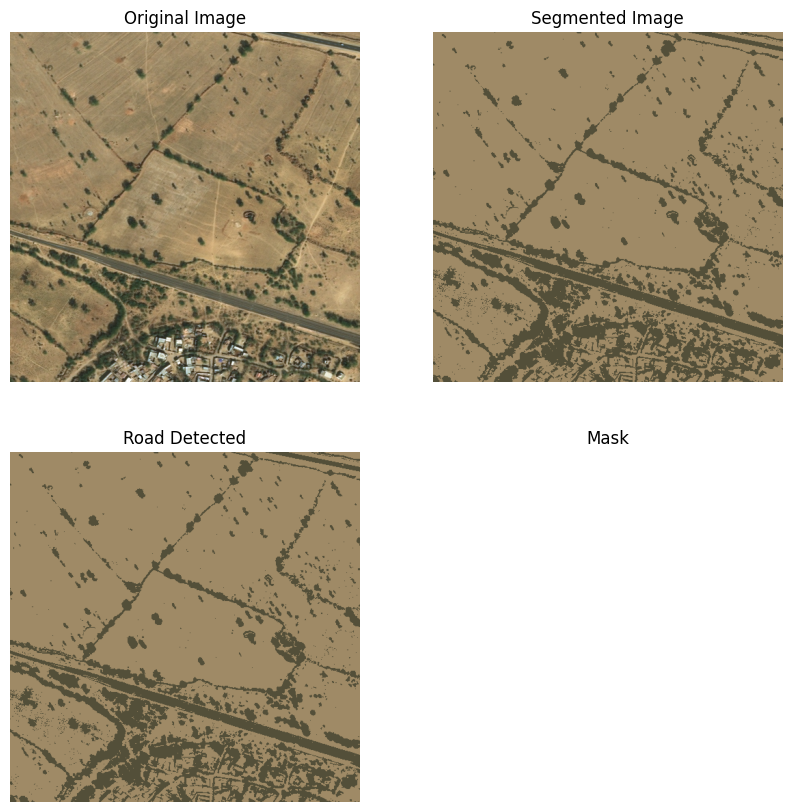

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def segment_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply K-means clustering
    Z = image.reshape((-1,3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2 # Number of clusters
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Reshape label to the size of original image
    label = label.reshape(image.shape[:2])

    # Assign a color to each cluster
    segmented_image = np.zeros_like(image)
    for i in range(K):
        segmented_image[label == i] = np.mean(image[label == i], axis=0)

    return segmented_image

def detect_road(image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define range of yellow color in HSV
    lower_yellow = np.array([18, 80, 80])
    upper_yellow = np.array([35, 255, 255])

    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image, image, mask=mask)

    return res, mask

# Read the image
image = cv2.imread('/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Test/14369_sat.jpg')

# Resize the image
height, width = image.shape[:2]
scale_percent = 50 # percent of original size
new_width = int(width * scale_percent / 100)
new_height = int(height * scale_percent / 100)
resized_image = cv2.resize(image, (new_width, new_height))

# Segment the image
segmented_image = segment_image(resized_image)

# Detect road
road_image, mask = detect_road(segmented_image)

# Display the images in columns with headings
images = {
    "Original Image": resized_image,
    "Segmented Image": segmented_image,
    "Road Detected": road_image,
    "Mask": mask
}

# Set up display parameters
cols = 2
rows = len(images) // cols + (len(images) % cols > 0)
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Display images
for i, (title, img) in enumerate(images.items()):
    ax = axs[i // cols, i % cols]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis('off')

# Remove any extra subplots
for i in range(len(images), rows * cols):
    fig.delaxes(axs.flatten()[i])

plt.show()


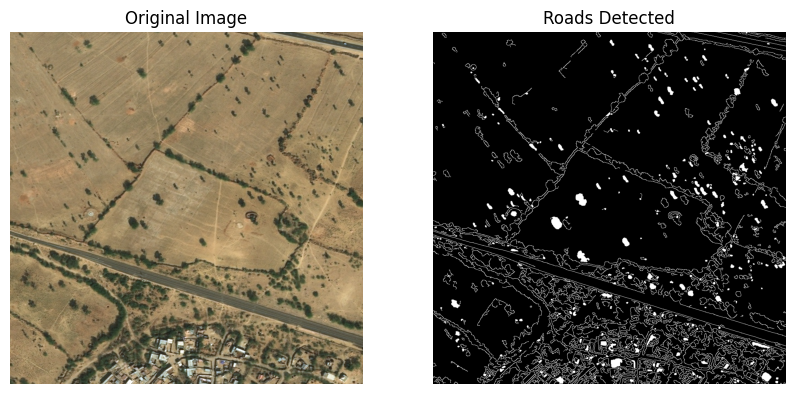

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

def detect_roads(image):
    # Use Canny edge detection
    edges = cv2.Canny(image, 50, 150)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw contours on a blank image
    road_image = np.zeros_like(image)
    cv2.drawContours(road_image, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    return road_image

# Read the satellite image
image = cv2.imread('/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Test/14369_sat.jpg')

# Preprocess the image
preprocessed_image = preprocess_image(image)

# Detect roads using contour detection
road_image = detect_roads(preprocessed_image)

# Display the original and road-detected images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(road_image, cv2.COLOR_BGR2RGB))
plt.title('Roads Detected')
plt.axis('off')

plt.show()


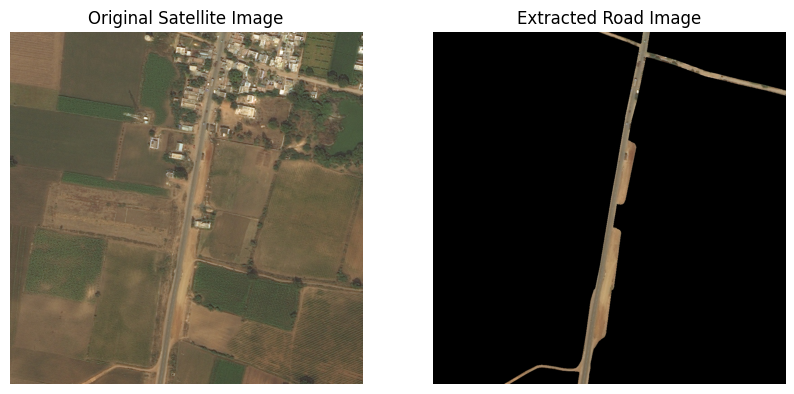

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def extract_road_from_mask(original_image, road_mask):
    # Convert the road mask to binary
    road_mask_binary = cv2.cvtColor(road_mask, cv2.COLOR_BGR2GRAY)
    _, road_mask_binary = cv2.threshold(road_mask_binary, 127, 255, cv2.THRESH_BINARY)

    # Use bitwise AND operation to extract road pixels from the original image
    road_image = cv2.bitwise_and(original_image, original_image, mask=road_mask_binary)

    return road_image

# Load the original image and road masked image
original_image = cv2.imread('/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Train/42359_sat.jpg')
road_mask = cv2.imread('/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Train/42359_mask.png')

# Extract the road pixels from the original image using the road mask
road_image = extract_road_from_mask(original_image, road_mask)

# Display the original image and the extracted road image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Satellite Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(road_image, cv2.COLOR_BGR2RGB))
plt.title('Extracted Road Image')
plt.axis('off')

plt.show()


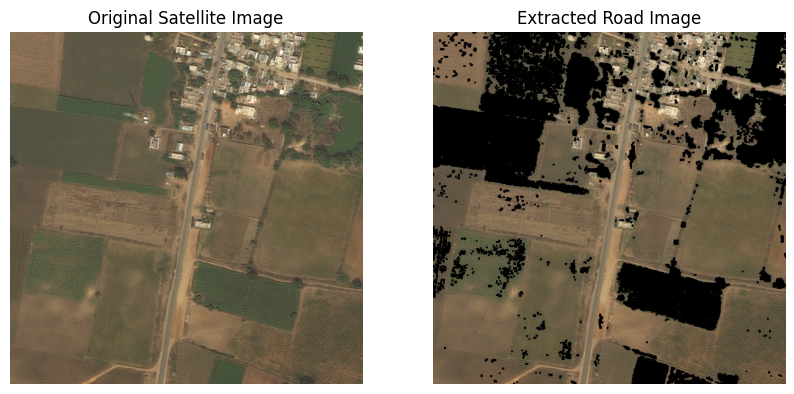

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def extract_road(original_image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)

    # Define lower and upper bounds for yellow color (assuming roads are yellowish)
    lower_yellow = np.array([15, 50, 100])
    upper_yellow = np.array([35, 255, 255])

    # Create a mask to isolate yellow regions
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Apply morphological operations to enhance the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Bitwise AND mask with original image
    road_image = cv2.bitwise_and(original_image, original_image, mask=mask)

    return road_image

# Load the original image
original_image = cv2.imread('/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Train/42359_sat.jpg')

# Extract the road pixels from the original image
road_image = extract_road(original_image)

# Display the original image and the extracted road image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Satellite Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(road_image, cv2.COLOR_BGR2RGB))
plt.title('Extracted Road Image')
plt.axis('off')

plt.show()


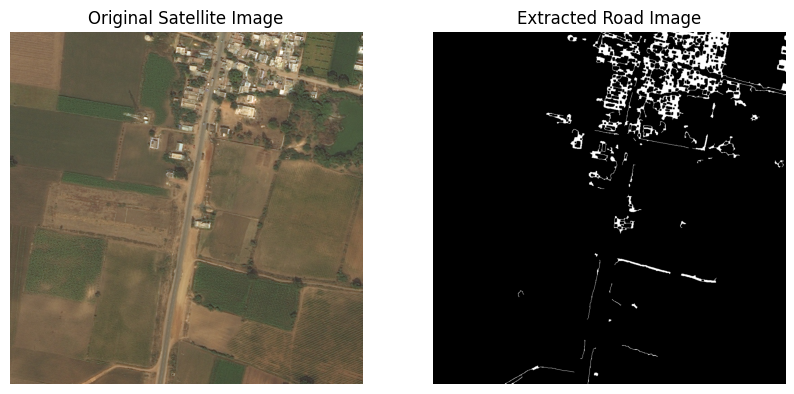

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def extract_road(original_image):
    # Convert image to grayscale
    gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Apply morphological operations to close gaps in the edges
    kernel = np.ones((5, 5), np.uint8)
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Convert closed edges to 3-channel image
    closed_edges = cv2.cvtColor(closed_edges, cv2.COLOR_GRAY2BGR)

    return closed_edges

# Load the original image
original_image = cv2.imread('/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Train/42359_sat.jpg')

# Extract the road pixels from the original image
road_image = extract_road(original_image)

# Display the original image and the extracted road image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Satellite Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(road_image, cv2.COLOR_BGR2RGB))
plt.title('Extracted Road Image')
plt.axis('off')

plt.show()


In [ ]:
pip install tensorflow keras

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Load pre-trained DeepLabv3+ model
model = tf.saved_model.load('/content/drive/MyDrive/EDUXLAB/Roads_Segmentation.hdf5')

def extract_road(original_image):
    # Preprocess input image
    img = cv2.resize(original_image, (512, 512))  # Resize to match model input size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values

    # Perform semantic segmentation
    seg_map = model(tf.convert_to_tensor(np.expand_dims(img, axis=0)))

    # Get road class index (e.g., if road class is index 7)
    road_class_index = 7

    # Create mask for road class
    road_mask = (seg_map[0].numpy().argmax(axis=-1) == road_class_index).astype(np.uint8) * 255

    # Apply the mask to the original image
    road_image = cv2.bitwise_and(original_image, original_image, mask=road_mask)

    return road_image

# Load the original image
original_image = cv2.imread('/content/drive/MyDrive/EDUXLAB/Roads _Extraction/Roads _Extraction/Train/42359_sat.jpg')

# Extract the road portion from the original image
road_image = extract_road(original_image)

# Display the road image
cv2.imshow('Road Image', road_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


OSError: SavedModel file does not exist at: /content/drive/MyDrive/EDUXLAB/Roads_Segmentation.hdf5/{saved_model.pbtxt|saved_model.pb}

In [ ]:
02/05/2024

In [ ]:
# Install necessary libraries
!pip install tensorflow numpy matplotlib



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Load DeepGlobe Road Extraction Dataset (assuming you have it stored in Google Drive)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define U-Net architecture
def unet_model():
    inputs = tf.keras.layers.Input((256, 256, 3))

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    up1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv3)
    merge1 = tf.keras.layers.Concatenate()([conv2, up1])
    conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge1)
    up2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    merge2 = tf.keras.layers.Concatenate()([conv1, up2])
    conv5 = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(merge2)

    return tf.keras.Model(inputs=inputs, outputs=conv5)

In [ ]:
# Compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Load and preprocess dataset
# Assuming X_train, y_train, X_val, y_val are loaded from DeepGlobe Road Extraction Dataset
# You need to adjust this part based on how you've stored and loaded your dataset
X_train = ...
y_train = ...
X_val = ...
y_val = ...

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Perform inference on test data (assuming X_test is loaded)
X_test = ...
predictions = model.predict(X_test)


In [ ]:
# Visualize some sample predictions
n_samples = 5
plt.figure(figsize=(15, 5))
for i in range(n_samples):
    plt.subplot(2, n_samples, i+1)
    plt.imshow(X_test[i])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(2, n_samples, i+1+n_samples)
    plt.imshow(predictions[i][:, :, 0], cmap='gray')
    plt.title('Predicted Road Mask')
    plt.axis('off')
plt.show()


In [ ]:
# Install necessary libraries
!pip install tensorflow numpy matplotlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load DeepGlobe Road Extraction Dataset (assuming you have it stored in Google Drive)
from google.colab import drive
drive.mount('/content/drive')

# Define U-Net architecture
def unet_model():
    inputs = tf.keras.layers.Input((256, 256, 3))

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    up1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv3)
    merge1 = tf.keras.layers.Concatenate()([conv2, up1])
    conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge1)
    up2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    merge2 = tf.keras.layers.Concatenate()([conv1, up2])
    conv5 = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(merge2)

    return tf.keras.Model(inputs=inputs, outputs=conv5)

# Load and preprocess dataset
# Assuming X_train, y_train, X_val, y_val are loaded from DeepGlobe Road Extraction Dataset
# You need to adjust this part based on how you've stored and loaded your dataset

# Define function to load images from directory
def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):  # assuming images are in jpg format
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (256, 256)) / 255.0  # preprocess: resize and normalize
            images.append(img)
    return images

# Define function to load masks from directory
def load_masks(directory):
    masks = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):  # assuming masks are in jpg format
            mask_path = os.path.join(directory, filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (256, 256)) / 255.0  # preprocess: resize and normalize
            mask[mask > 0.5] = 1  # Binarize mask
            mask[mask <= 0.5] = 0
            masks.append(mask)
    return masks

# Load images and masks
train_images = load_images("/content/drive/MyDrive/dataset/road satellite data/road extraction/train")
train_masks = load_masks("/content/drive/MyDrive/dataset/road satellite data/road extraction/train")
val_images = load_images("/content/drive/MyDrive/dataset/road satellite data/road extraction/valid")
val_masks = load_masks("/content/drive/MyDrive/dataset/road satellite data/road extraction/valid")

# Convert lists to numpy arrays
X_train = np.array(train_images)
y_train = np.array(train_masks)
X_val = np.array(val_images)
y_val = np.array(val_masks)

# Compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Perform inference on test data (assuming X_test is loaded)
# Load test images
test_images = load_images("/content/drive/MyDrive/dataset/road satellite data/road extraction/test")

# Convert to numpy array
X_test = np.array(test_images)

# Make predictions
predictions = model.predict(X_test)

# Visualize some sample predictions
n_samples = 5
plt.figure(figsize=(15, 5))
for i in range(n_samples):
    plt.subplot(2, n_samples, i+1)
    plt.imshow(X_test[i])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(2, n_samples, i+1+n_samples)
    plt.imshow(predictions[i][:, :, 0], cmap='gray')
    plt.title('Predicted Road Mask')
    plt.axis('off')
plt.show()
